In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import torch
import torch.nn as nn 
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

### Momentum Iteration Method (FGSM)
- targeted attack

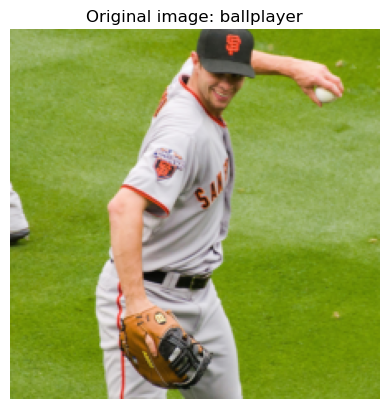

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image= "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)
output = model(image_tensor)
_, predict = torch.max(output,1)

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

plt.imshow(original_image)
plt.title(f"Original image: {labels}")
plt.axis("off")
plt.show()

In [14]:
def mim_fgsm(image, target, decay_factor, epsilon, alpha, num_iter):
    target = torch.tensor([target]).to(device)
    perturbed_image = image.clone().detach().to(device)
    momentum = torch.zeros_like(image)

    perturbed_image.requires_grad = True

    for _ in tqdm(range(num_iter),desc="Momentum Itersion"):
        output = model(perturbed_image)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output, target)

        model.zero_grad()
        loss.backward(retain_graph=True)

        data_grad = perturbed_image.grad.data

        momentum = momentum * decay_factor + data_grad / torch.norm(data_grad, p=1)
        perturbed_image = perturbed_image + alpha * momentum.sign()
        perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
        perturbed_image = perturbed_image.detach().requires_grad_(True)
    
    return perturbed_image

Momentum Itersion: 100%|██████████| 1000/1000 [00:12<00:00, 79.87it/s]


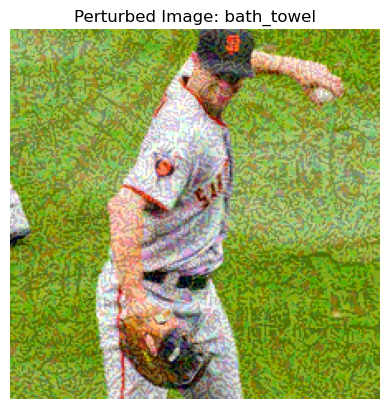

In [16]:
decay_factor = 0.8
epsilon = 0.1
alpha = 1
num_iter = 1000
target = 2

adversarial_image = mim_fgsm(image_tensor, target, decay_factor, epsilon, alpha, num_iter)

adversarial_output = model(adversarial_image)

_ , adversarial_predict = torch.max(adversarial_output, 1)

adversarial_labels = idx2label[adversarial_predict.item()]

perturbed_image = adversarial_image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

plt.imshow(perturbed_image)
plt.title(f"Perturbed Image: {adversarial_labels}")
plt.axis("off")
plt.show()